<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/Projet2_XAI_Tutorial_DIverse_Counterfactual_Explanations_(DICE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIverse Counterfactual Explanations (DICE)

Nous nous focalisons ici sur l'utilisation de la méthode DiCE (article: Mothilal et al.[[1](https://arxiv.org/pdf/1905.07697.pdf)]) en utilisant le cadre de travail développée par Mothilal, Sharma et Tan https://github.com/interpretml/DiCE.



## Comment DICE génère une explication contrefactuelle ?

L'idée principale est de générer un ensemble de k exemples contrefactuels ${c_1, c_2, ..., c_k}$ de sorte que la décision du modèle $f$ donnée une instance $x$ change. Cependant, il faut prendre en compte que générer des exemples contrefactuels avec un grand nombre de caractéristiques ayant changé n'est pas l'approche idéale (Diversité). D'autre part, nous devons considérer des exemples contrefactuels proches de l'instance originale $x$ (Proximité), sinon les explications ne seront pas utiles.

Diversité via le Processus de Points Déterminant :

\begin{gather} dpp_diversity = \det(K) \end{gather} où $K_{i,j} = \frac{1}{1+dist(c_i,c_j)} $ et $dist(c_i,c_j)$ est une métrique de distance.

Proximité : \begin{gather} Proximity := -\frac{1}{k} \sum_{i=1}^{k} dist(c_i, x) \end{gather}

Au-delà de ces principales contraintes, DiCE permet d'implémenter des contraintes qui sont liées à des problèmes du "monde réel" (par exemple, une borne supérieure pour certaines variables).

Sur la base de ces définitions, DiCE considère la fonction de perte suivante à optimiser :

\begin{gather} C(x) = \arg; \min_{c_1, c_2, ..., c_k} \frac{1}{k}\sum_{i=1}^{k} yloss(f(c_i), y) + \frac{\lambda_1}{k} \sum_{i=1}^{k} dist(c_i, x) \ - \lambda_2 dpp_diversity(c_1, c_2, ..., c_k) \end{gather}

où $yloss()$ est une fonction qui mesure la distance entre $f(c_i)$ et le résultat souhaité $y$. Les deux hyperparamètres $\lambda_1$ et $\lambda_2$ équilibrent les trois parties de la fonction de perte.

#**Plan de ce notebook**


Nous avons tout d'abord tenté d'utiliser le jeu de données "adult income dataset" : en vain, DICE ne parvenant à trouver aucun exemple contrefactuel. Ce, malgré la modification des paramètres de DICE, puis du modèle lui-même.

Nous avons donc ensuite utilisé le jeu de données breast_cancer de scikit-learn, qui nous a permis de faire fonctionner DICE facilement et de façon concluante.

## Use Case: adult income dataset

Nous avons tenté d'utiliser la méthode sur le jeu de données "Adulte income dataset (census income dataset)" de kaggle, qui consiste en extraits de la base de données du recensement de 1994 aux USA. L'extraction a été effectuée en utilisant les conditions suivantes : ((AAGE>16) & (AGI>100) & (AFNLWGT>1) & (HRSWK>0)).

L'idée était de déterminer si une personne gagne plus de 50 000 $ par an, selon ses caractéristiques pour ce recensement.

Les données sont pondérées par la variable fnlwgt (poids final).

Ce jeu de données contient 48 842 entrées. Chaque entrée contenant les informations suivantes sur un individu :

● age : l'âge de l'individu
Entier supérieur à 0

● workclass : un terme général pour représenter le statut d'emploi de l'individu
 Privé, Indépendant non déclaré, Indépendant déclaré, Gouvernement fédéral, Gouvernement local, Gouvernement d'État, Sans salaire, Jamais travaillé

● fnlwgt : poids final. Autrement dit, c'est le nombre de personnes que le recensement estime que l'entrée représente
Entier supérieur à 0

● education : le niveau d'éducation le plus élevé atteint par un individu
Baccalauréat, Quelques années d'université, 11e, Diplôme de lycée, École professionnelle, Associé académique, Associé professionnel, 9e, 7e 8e, 12e, Maîtrise, 1er 4e, 10e, Doctorat, 5e 6e, Maternelle

● education num : le niveau d'éducation atteint sous forme numérique
Entier supérieur à 0

● marital status : statut marital de l'individu. "Married civ spouse" correspond à un conjoint civil, tandis que "Married AF spouse" est un conjoint dans les forces armées
Conjoint civil marié, Divorcé, Jamais marié, Séparé, Veuf, Conjoint absent marié, Conjoint militaire marié

● occupation : le type général d'occupation de l'individu
 Support technique, Réparation artisanale, Autres services, Ventes, Direction exécutive, Spécialité professionnelle, Manutentionnaires nettoyeurs, Opérateur de machines, Administration, Agriculture pêche, Transport déménagement, Service domestique privé, Services de protection, Forces armées

● relationship : représente ce que cet individu est par rapport aux autres. Par exemple, un individu peut être un mari. Chaque entrée n'a qu'une seule valeur de relation et est en quelque sorte redondante avec le statut marital. Nous pourrions ne pas utiliser cet attribut du tout
Femme, Enfant à charge, Mari, Hors famille, Autre parent, Célibataire

● race : Description de la race de l'individu
Blanc, Asiatique Pacifique, Indien Américain Eskimo, Autre, Noir

● sex : sexe biologique de l'individu
Masculin, Féminin

● capital gain : gains en capital d'un individu
Entier supérieur ou égal à 0

● capital loss : pertes en capital d'un individu
Entier supérieur ou égal à 0

● hours per week : le nombre d'heures qu'un individu a rapporté travailler par semaine

● native country : pays d'origine de l'individu
États-Unis, Cambodge, Angleterre, Porto Rico, Canada, Allemagne, États-Unis périphériques (Guam USVI, etc.), Inde, Japon, Grèce, Sud, Chine, Cuba, Iran, Honduras, Philippines, Italie, Pologne, Jamaïque, Vietnam, Mexique, Portugal, Irlande, France, République Dominicaine, Laos, Équateur, Taïwan, Haïti, Colombie, Hongrie, Guatemala, Nicaragua, Écosse, Thaïlande, Yougoslavie, Salvador, Trinité-et-Tobago, Pérou, Hong Kong, Pays-Bas

● the label : si l'individu gagne plus de 50 000 $ par an
 <=50k, >50k

Nous avons procédé en trois étapes :
1. Chargement et examen du jeu de données
2. Développement d'un modèle explicatif du label : un random forest.
3. Application de DICE pour générer une explication contrefactuelle (https://github.com/interpretml/DiCE).


In [ ]:
################## Downdload the git repository ############
! git clone https://github.com/ayoubelqadi/xai-tutorial.git

Cloning into 'xai-tutorial'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 94 (delta 20), reused 86 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 5.80 MiB | 8.59 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
######### Change  directory for running the data processing scripts
import os
os.chdir('xai-tutorial/notebooks')

In [ ]:
%run ../src/setup.py
%run ../src/process_data.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Paramétrage de l'environnement

In [ ]:
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=16)

from sklearn import metrics
from sklearn import model_selection


In [ ]:
path="/content/drive/MyDrive/donnees/adult.csv"
df = pd.read_csv(path)

Nous étudions le dataset non pondéré, car notre but n'est pas de sortir des chiffres portant sur la population des états-unis, mais d'identifier des variables, des caractéristiques, déterminant le niveau de revenus (inférieur ou supérieur au seuil de 50000$).

In [ ]:
variables = df.columns.tolist()

# Afficher les variables
print("Toutes les variables dans le DataFrame :")
for var in variables:
    print(var)

Toutes les variables dans le DataFrame :
age
workclass
fnlwgt
education
education.num
marital.status
occupation
relationship
race
sex
capital.gain
capital.loss
hours.per.week
native.country
income


In [ ]:
print(df.head())

   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States

In [ ]:
# Compter le nombre de valeurs manquantes pour chaque colonne
missing_values = df.isnull().sum()

# Afficher les résultats
print("Nombre de valeurs manquantes par colonne :")
print(missing_values)

Nombre de valeurs manquantes par colonne :
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [ ]:
# Obtenir la liste des modalités pour chaque colonne
modalites = {col: df[col].unique().tolist() for col in df.columns}

# Afficher les modalités
print("Modalités pour chaque colonne :")
for col, mod in modalites.items():
    print(f"{col}: {mod}")

Modalités pour chaque colonne :
age: [90, 82, 66, 54, 41, 34, 38, 74, 68, 45, 52, 32, 51, 46, 57, 22, 37, 29, 61, 21, 33, 49, 23, 59, 60, 63, 53, 44, 43, 71, 48, 73, 67, 40, 50, 42, 39, 55, 47, 31, 58, 62, 36, 72, 78, 83, 26, 70, 27, 35, 81, 65, 25, 28, 56, 69, 20, 30, 24, 64, 75, 19, 77, 80, 18, 17, 76, 79, 88, 84, 85, 86, 87]
workclass: ['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc', 'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked']
fnlwgt: [77053, 132870, 186061, 140359, 264663, 216864, 150601, 88638, 422013, 70037, 172274, 164526, 129177, 136204, 172175, 45363, 172822, 317847, 119592, 203034, 188774, 77009, 29059, 153870, 135285, 34310, 228696, 122066, 107164, 175360, 44064, 107287, 198863, 123011, 205246, 39181, 149650, 197163, 137527, 161691, 326232, 115806, 115066, 289669, 100820, 121253, 110380, 233882, 192052, 174995, 335549, 237729, 68898, 107276, 141584, 207668, 313243, 147372, 237608, 194901, 155106, 121441, 162028, 160724, 132222, 226355, 329980,

S'il n'y a pas de valeurs manquantes, il y a en revanche une modalité "?" présente dans plusieurs colonnes...

In [ ]:
# Trouver les effectifs de la modalité "?" pour chaque colonne
effectifs_question_mark = {col: (df[col] == "?").sum() for col in df.columns}

# Afficher les effectifs
print("Effectifs de la modalité '?' pour chaque colonne :")
for col, count in effectifs_question_mark.items():
    print(f"{col}: {count}")

Effectifs de la modalité '?' pour chaque colonne :
age: 0
workclass: 1836
fnlwgt: 0
education: 0
education.num: 0
marital.status: 0
occupation: 1843
relationship: 0
race: 0
sex: 0
capital.gain: 0
capital.loss: 0
hours.per.week: 0
native.country: 583
income: 0


Cela représente environ 4% des répondants pour la variable "workclass", ainsi que pour la variable "occupation", et environ 2% pour la variable "native country".

### Distribution de la variable à expliquer


Les 2/3 de notre échantillon ont un revenu inférieur à 50000$.

<Axes: >

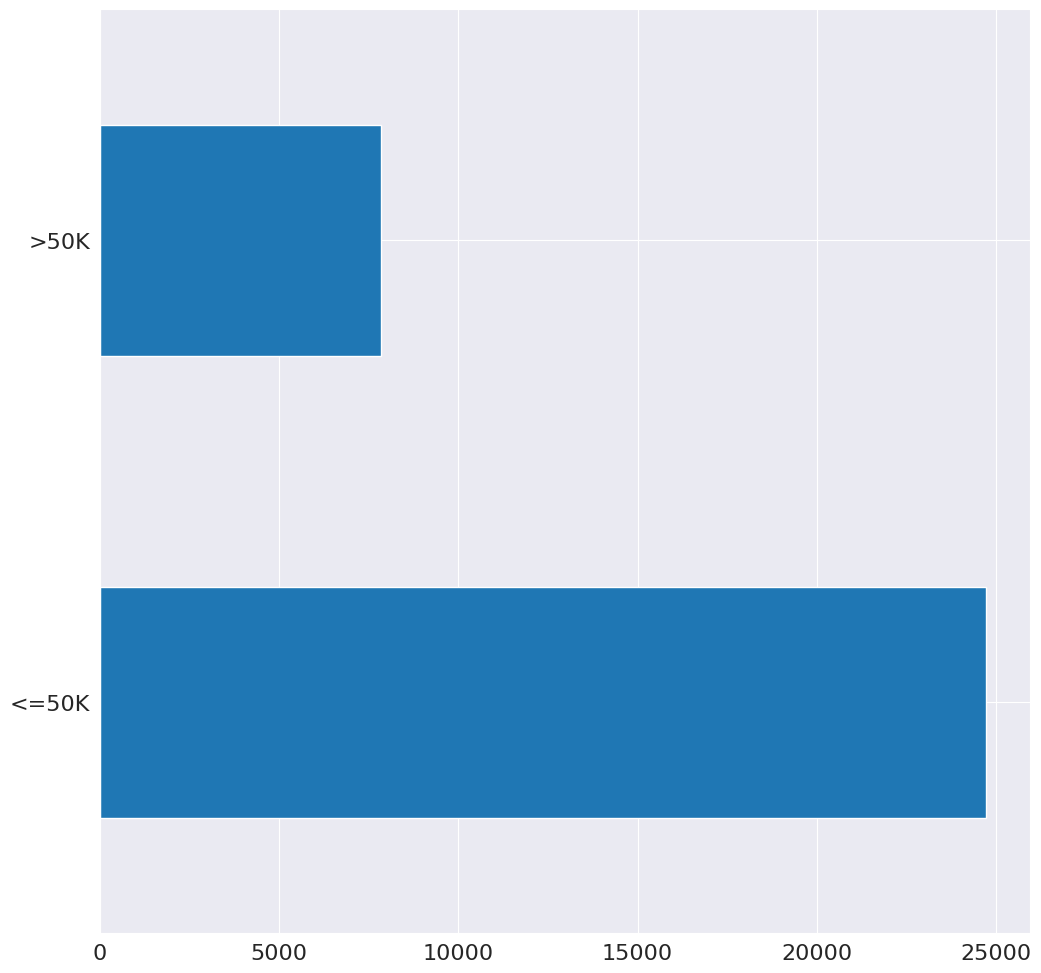

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,12))
counter = df["income"].value_counts()

ax.set_xlabel("# Effectifs", size=16)
counter.plot(kind="barh", ax=ax)

Les personnes à haut revenu (>50000$) sont plus âgées, plus souvent de sexe masculin, de race blanche (déclarée au recensement), de haut niveau d'éducation (en particulier : doctorate, masters, prof-school), et mariés. Elles ont un nombre de "hours per week" supérieur aux autres. Leur workclass est plus souvent "self-emp-inc" ou "federal gouv", et leur occupation "craft repair" ou "priv-house-serv".

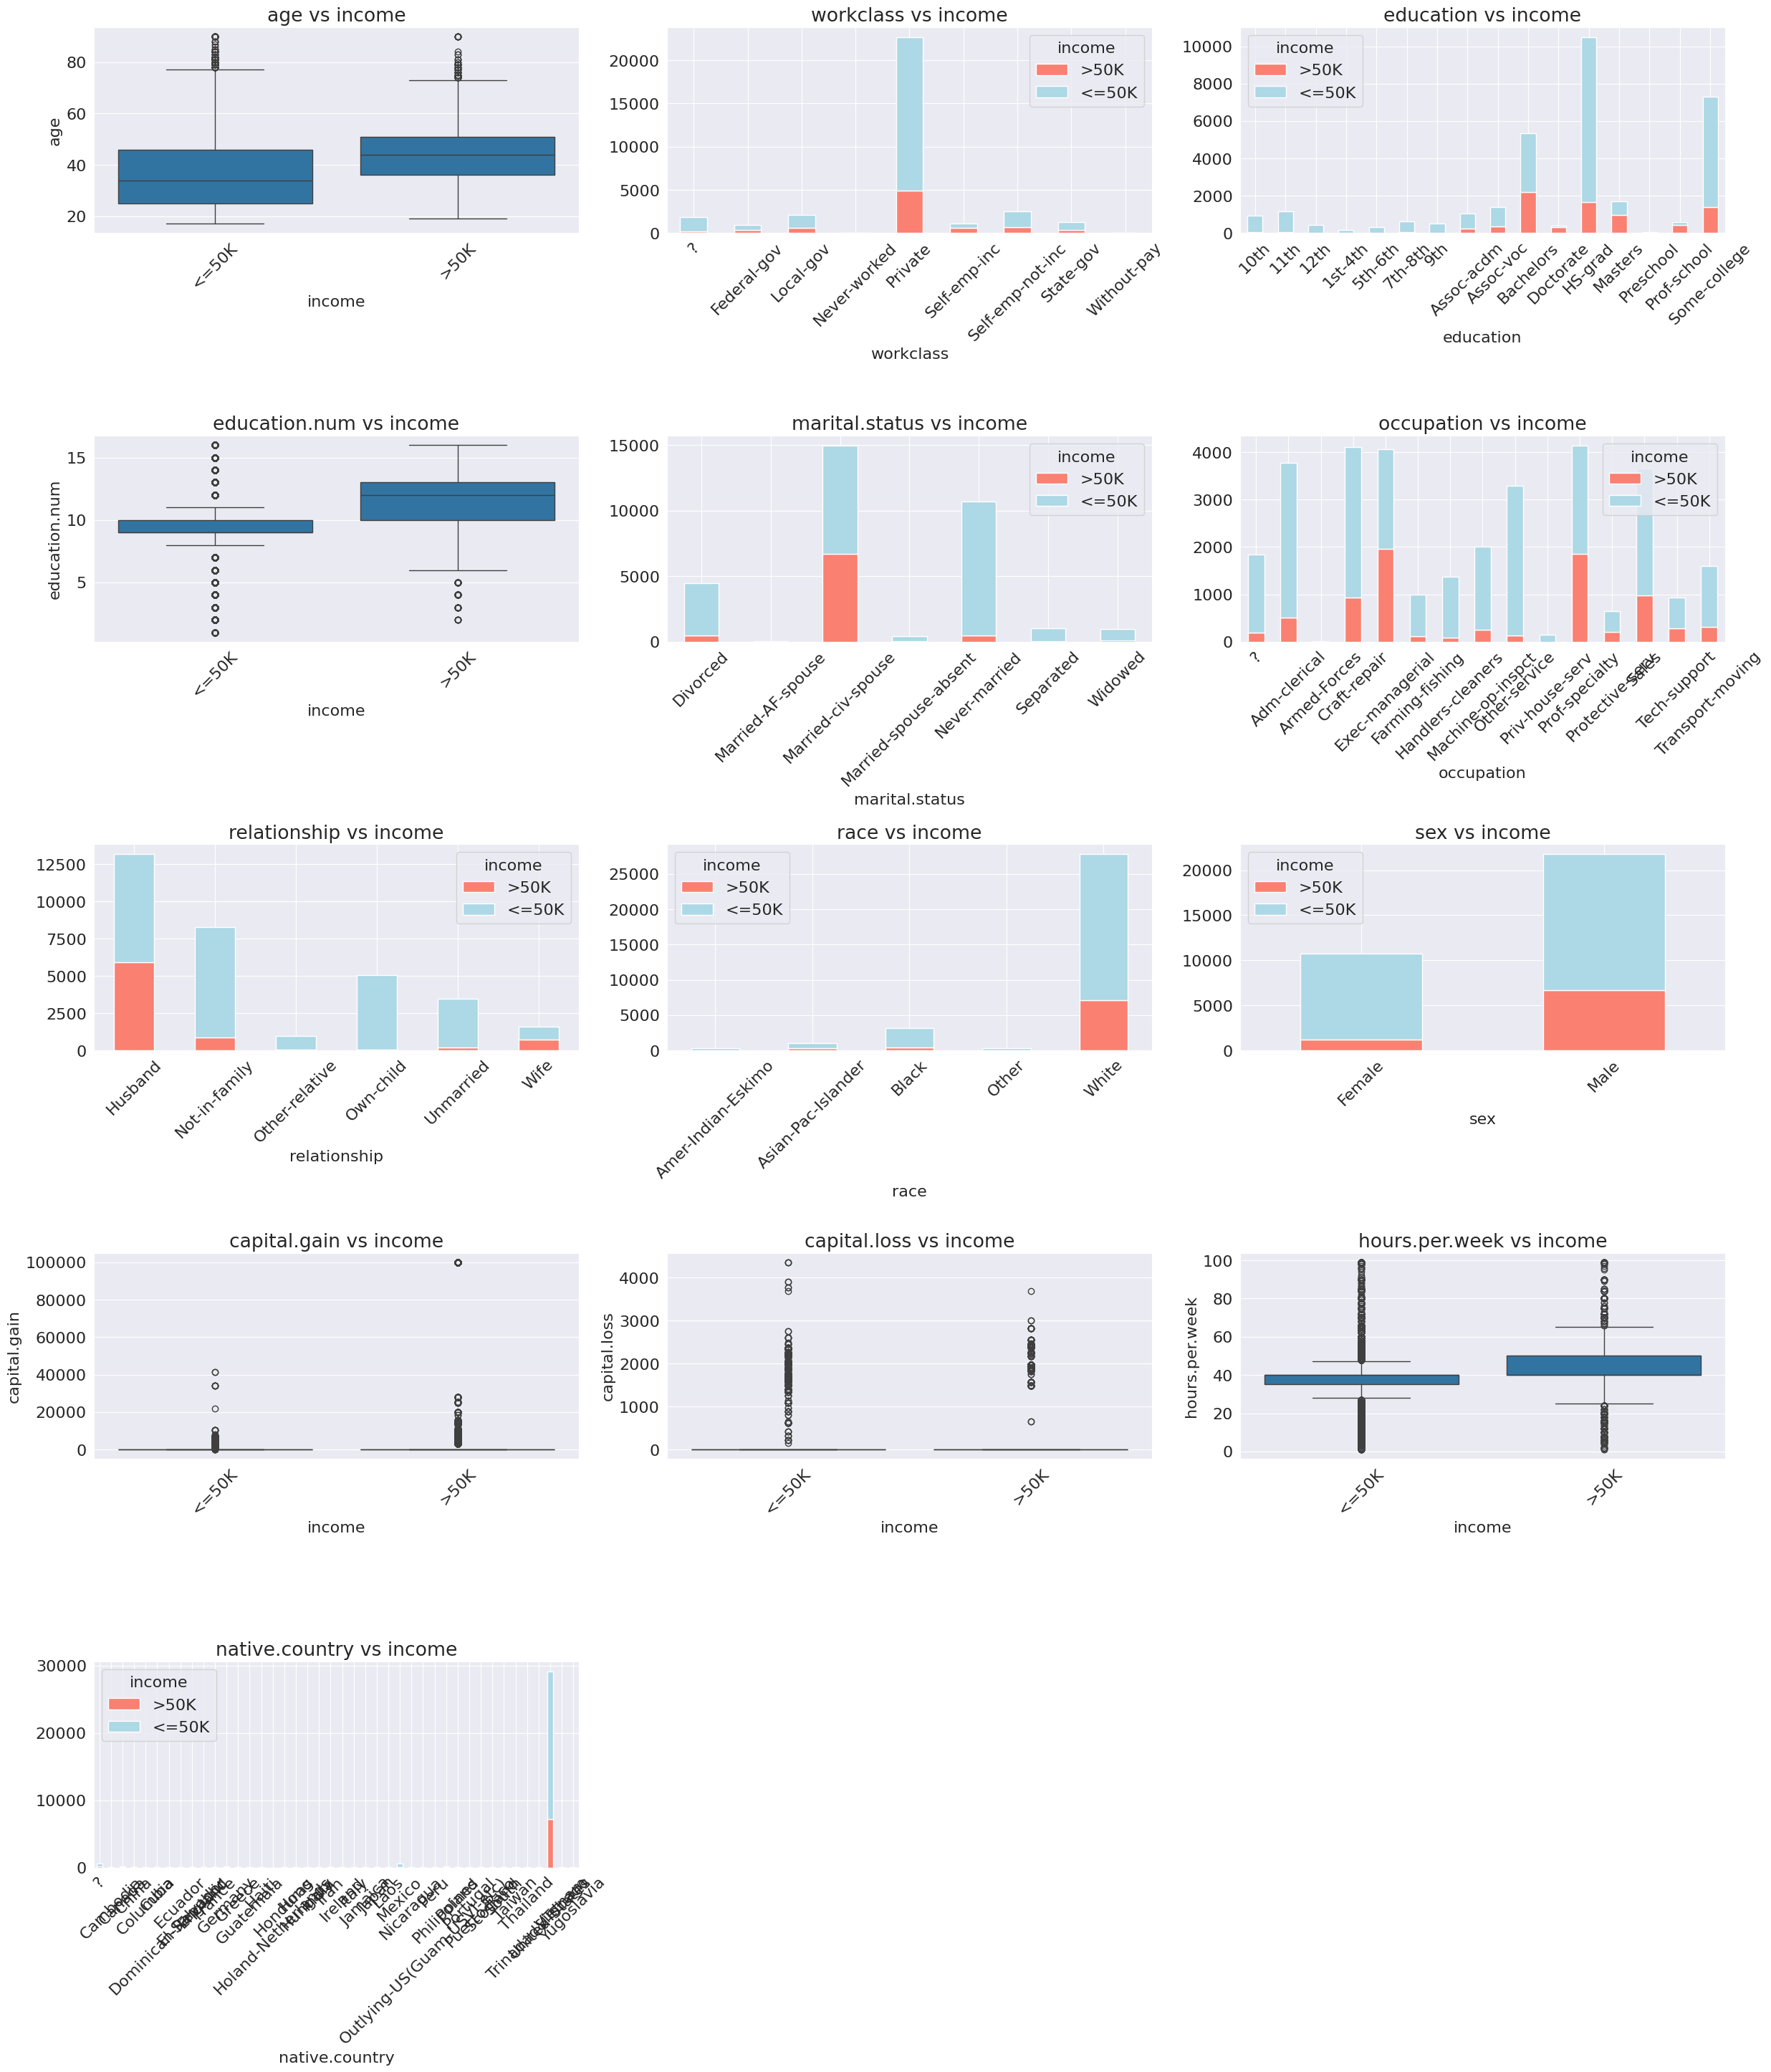

In [ ]:
# Liste des variables à analyser
variables = [
    "age", "workclass", "education", "education.num",
    "marital.status", "occupation", "relationship", "race",
    "sex", "capital.gain", "capital.loss", "hours.per.week", "native.country"
]

# Nombre de lignes et de colonnes pour le subplot
n_rows = len(variables) // 3 + (len(variables) % 3 > 0)

# Création de la figure
plt.figure(figsize=(25, 6 * n_rows))

# Itérer sur chaque variable et créer le graphique
for i, var in enumerate(variables, 1):
    plt.subplot(n_rows, 3, i)  # Crée une sous-figure
   # if df[var].dtype == "object":  # Si la variable est catégorielle
    #    sns.countplot(x=var, hue='income', data=df)  # Countplot pour les variables catégorielles

    if df[var].dtype == "object":  # Si la variable est catégorielle
        # Calculer le nombre d'occurrences de chaque catégorie et income
        count_data = pd.crosstab(df[var],df['income'], margins=False)

        # Réorganiser les colonnes pour que >50K soit affiché avant <=50K
        count_data = count_data[['>50K','<=50K']]

        # Création du graphique à barres empilées
        count_data.plot(kind='bar', stacked=True, ax=plt.gca(), color=['salmon','lightblue'])

    else:  # Si la variable est numérique
        sns.boxplot(x='income', y=var, data=df)  # Boxplot pour les variables numériques

    plt.title(f"{var} vs income")
    plt.tight_layout()

    # Incliner les labels de l'axe des abscisses à 45°
    plt.xticks(rotation=45)


# Afficher les graphiques
plt.show()

## Mise en place du modèle

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

x_train, x_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=14,
                                                                    stratify=y)

In [ ]:
x_train

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
8446,35,Private,193026,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States
10876,31,Self-emp-inc,455995,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,65,United-States
26609,34,Private,329587,10th,6,Separated,Other-service,Not-in-family,White,Female,0,0,35,United-States
31511,51,Private,293802,5th-6th,3,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,52,United-States
26033,27,Private,119793,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30878,36,Private,150548,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,30,United-States
32480,36,Private,186819,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,52,United-States
14948,59,?,254765,Some-college,10,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States
20728,37,Self-emp-not-inc,36214,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,65,United-States


### Entrainement du modèle




In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
categoric_features = [

    'workclass',
    'education',
    'marital.status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native.country'
]
numeric_features = set(X.columns)-set(categoric_features)

**nous précisons à l'encodeur catégoriel les différentes catégories de chaque variable catégorielle.**

In [ ]:
cat_types = []
for cat in categoric_features:
    cat_i = list(X[cat].unique())
    cat_types.append(cat_i)

In [ ]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(categories=cat_types))])
preprocessor = ColumnTransformer(transformers=[('categorical', categorical_transformer, categoric_features)])

In [ ]:
params_rf = {
    "n_estimators": 100,
    "max_depth": 5,
    "random_state":27,
}
rf = RandomForestClassifier(**params_rf)

In [ ]:
import pandas as pd
x_train = pd.DataFrame(x_train, columns=X.columns)
x_test = pd.DataFrame(x_test, columns=X.columns)

#Model object: takes original data, processes it and applies the random forest
clf_rf = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', rf)
])
model = clf_rf.fit(x_train, y_train)

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

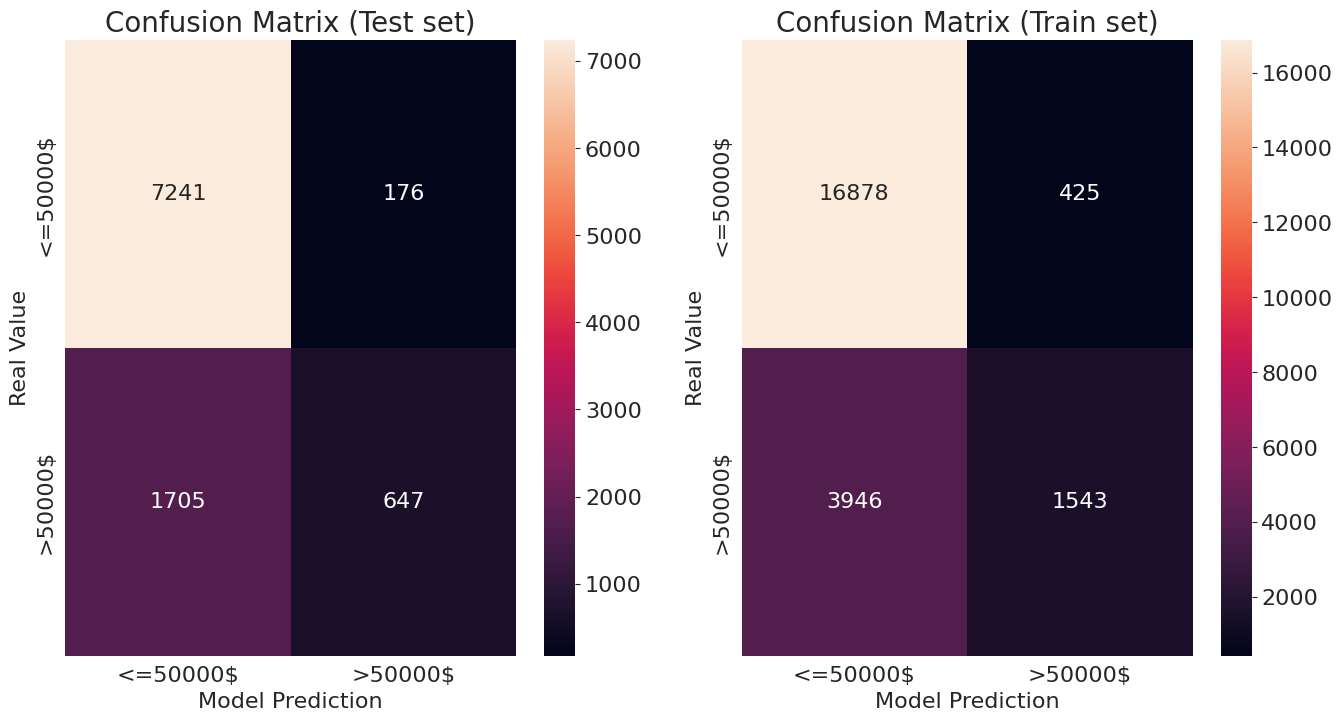

In [ ]:
y_hat = clf_rf.predict(x_test)
cf = metrics.confusion_matrix(y_pred=y_hat, y_true=y_test)
cf_train = metrics.confusion_matrix(y_pred=clf_rf.predict(x_train), y_true=y_train)
names_df = [
    "<=50000$",
    ">50000$"
]
cf_df = pd.DataFrame(data=cf, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.heatmap(cf_df, fmt="d",annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

sns.heatmap(cf_train_df, fmt="d",annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)

##DICE

In [ ]:
#Loading the dice module
import dice_ml
from dice_ml.utils import helpers
import json

In [ ]:
#DiCE data object
X2 = pd.concat([X,y], axis=1)
#{1.0: ">50000$", 0.0: "<=50000$"}
data = dice_ml.Data(dataframe=X2, continuous_features=list(numeric_features), outcome_name='income')
#DiCE model object
model_exp = dice_ml.Model(model=model, backend='sklearn')
#Creates the explanations
exp = dice_ml.Dice(data, model_exp, method="random")

In [ ]:
adult_index = 22

# Patient real target value
income_map = {1.0: ">50000$",
                0.0: "<=50000$"}
print("-------Adult Real Income------")

print(y.replace(income_map).iloc[adult_index])
print("-------Adult Predicted Income------")
pred_class = clf_rf.predict(X.loc[adult_index:adult_index, :])[0]
if pred_class==0.0:
    pred_income = income_map[0.0]
    p1 = clf_rf.predict_proba(X.loc[adult_index:adult_index, :])[0][0]
    p1_round = round(p1,3)
else:
    pred_income = income_map[1.0]
    p1 = clf_rf.predict_proba(X.loc[adult_index:adult_index, :])[0][1]
    p1_round = round(p1,3)
print(f'Probability of having an income {pred_income} \n{p1_round}')

-------Adult Real Income------
<=50K
-------Adult Predicted Income------
Probability of having an income >50000$ 
0.088


DICE ne parvient pas à trouver d'exemple contrefactuel satisfaisant les contraintes mises dans la cellule ci-dessous :

In [ ]:
#We take an example of our training set
#We set the number of counterfactual explanations to 2.
#patient_index = 2
features_to_vary = [
   'workclass',
    'education',
    'marital.status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native.country'
]
e1 = exp.generate_counterfactuals(X[adult_index:adult_index+1],
                                  total_CFs=5,
                                  desired_class="same",
                                  random_seed=3434,
                                  features_to_vary=features_to_vary)
#Show counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=False)

  0%|          | 0/1 [00:00<?, ?it/s]


UserConfigValidationException: The target class for same could not be identified

Cela ne marche pas non plus en nous restreignant aux variables directement numériques :

In [ ]:
adult_index = 22

# Obtenir la classe prédite pour l'instance originale
original_prediction = clf_rf.predict(X[adult_index:adult_index+1])[0]


# Mapper la prédiction à des étiquettes numériques si nécessaire
# En supposant que votre modèle utilise 0 pour '<=50K' et 1 pour '>50K'
desired_class_num = 0 if original_prediction == '<=50K' else 1

# Inverser la classe pour obtenir la classe opposée
opposite_class_num = 1 - desired_class_num

# Générer des contre-exemples avec la même classe prédite
e1 = exp.generate_counterfactuals(
    X[adult_index:adult_index+1],
    total_CFs=5,
    #desired_class=original_prediction,  # Utiliser la prédiction originale ici
    desired_class=opposite_class_num,  # Utiliser l'étiquette numérique ici
    #random_seed=3434,
    features_to_vary=['age', 'education.num', 'hours.per.week', 'workclass']
)

# Afficher les contre-exemples
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

# Application de DICE aux données cancer_breast de scikit learn

### Paramétrage de l'environnement


In [ ]:
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=16)

from sklearn import metrics
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


Chargement du jeu de données

In [ ]:
from sklearn.datasets import load_breast_cancer

# Charger le jeu de données
data = load_breast_cancer()

# Créer un DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)


# Ajouter la colonne cible
df['target'] = data.target


# Séparer les features  et la cible
features = df.drop(columns=["target"])
target = df["target"]

In [ ]:
print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [ ]:
variables = df.columns.tolist()

# Afficher les variables
print("Toutes les variables dans le DataFrame :")
for var in variables:
    print(var)

Toutes les variables dans le DataFrame :
mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
mean fractal dimension
radius error
texture error
perimeter error
area error
smoothness error
compactness error
concavity error
concave points error
symmetry error
fractal dimension error
worst radius
worst texture
worst perimeter
worst area
worst smoothness
worst compactness
worst concavity
worst concave points
worst symmetry
worst fractal dimension
target


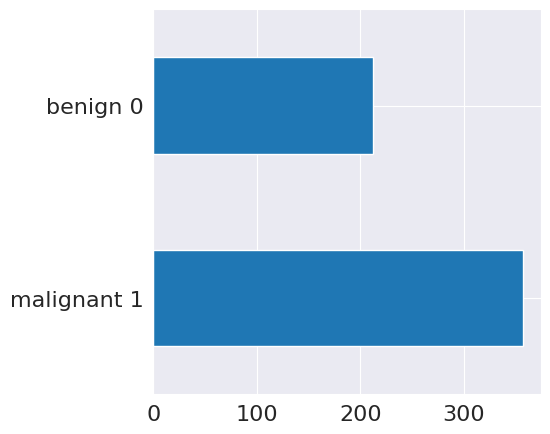

In [ ]:
# Configuration de l'affichage
import matplotlib.pyplot as plt  # Importing matplotlib
import seaborn as sns

# Configuration de l'affichage
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(5, 5))

# Compter et renommer les classes
counter = target.value_counts()
counter.rename(index={1.0: "malignant 1", 0.0: "benign 0"}, inplace=True)
ax.set_xlabel("# Cases", size=7)
counter.plot(kind="barh", ax=ax)
plt.show()

In [ ]:
x, y = features, target

x_train, x_test, y_train, y_test = model_selection.train_test_split(x,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=80,
                                                                    stratify=target)

In [ ]:
x_train


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
34,16.130,17.88,107.00,807.2,0.10400,0.15590,0.13540,0.077520,0.1998,0.06515,...,20.210,27.26,132.70,1261.0,0.14460,0.58040,0.52740,0.18640,0.4270,0.12330
231,11.320,27.08,71.76,395.7,0.06883,0.03813,0.01633,0.003125,0.1869,0.05628,...,12.080,33.75,79.82,452.3,0.09203,0.14320,0.10890,0.02083,0.2849,0.07087
88,12.360,21.80,79.78,466.1,0.08772,0.09445,0.06015,0.037450,0.1930,0.06404,...,13.830,30.50,91.46,574.7,0.13040,0.24630,0.24340,0.12050,0.2972,0.09261
560,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.043040,0.1537,0.06171,...,15.300,33.17,100.20,706.7,0.12410,0.22640,0.13260,0.10480,0.2250,0.08321
192,9.720,18.22,60.73,288.1,0.06950,0.02344,0.00000,0.000000,0.1653,0.06447,...,9.968,20.83,62.25,303.8,0.07117,0.02729,0.00000,0.00000,0.1909,0.06559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,13.240,20.13,86.87,542.9,0.08284,0.12230,0.10100,0.028330,0.1601,0.06432,...,15.440,25.50,115.00,733.5,0.12010,0.56460,0.65560,0.13570,0.2845,0.12490
459,9.755,28.20,61.68,290.9,0.07984,0.04626,0.01541,0.010430,0.1621,0.05952,...,10.670,36.92,68.03,349.9,0.11100,0.11090,0.07190,0.04866,0.2321,0.07211
142,11.430,17.31,73.66,398.0,0.10920,0.09486,0.02031,0.018610,0.1645,0.06562,...,12.780,26.76,82.66,503.0,0.14130,0.17920,0.07708,0.06402,0.2584,0.08096
488,11.680,16.17,75.49,420.5,0.11280,0.09263,0.04279,0.031320,0.1853,0.06401,...,13.320,21.59,86.57,549.8,0.15260,0.14770,0.14900,0.09815,0.2804,0.08024


In [ ]:
# Calculer le poids des classes
proportion_class =   counter["malignant 1"]/counter["benign 0"]

# Paramètres XGBoost
params_xgb = {
    "n_estimators": 200,
    "max_depth": 8,
    "learning_rate": 0.05,
    "scale_pos_weight": proportion_class,
}

In [ ]:
# Modèle XGBoost
xgb = XGBClassifier(**params_xgb)
xgb.fit(x_train, y_train)

# Évaluation
y_pred = xgb.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


L'accuracy du modèle est très bonne sur l'ensemble de test.

In [ ]:
y_hat = xgb.predict(x_test)
y_hat = xgb.predict(x_test)
cf = metrics.confusion_matrix(y_pred=y_hat, y_true=y_test)
cf_train = metrics.confusion_matrix(y_pred=xgb.predict(x_train), y_true=y_train)
names_df = [
    "benign",
    "malignant"
]

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

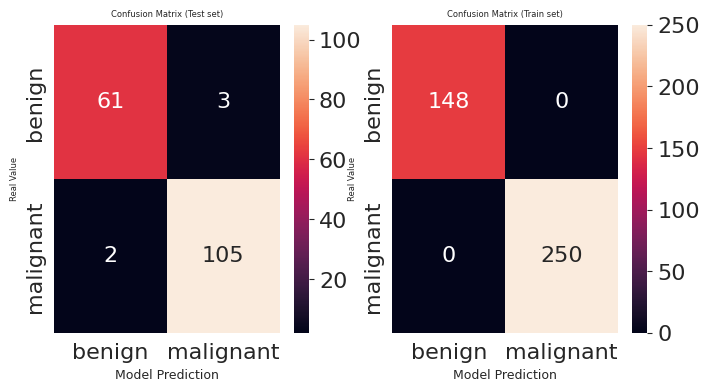

In [ ]:
cf_df = pd.DataFrame(data=cf, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

sns.heatmap(cf_df, fmt="d",annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=9)
ax[0].set_ylabel("Real Value", size=6)
ax[0].set_title("Confusion Matrix (Test set)", size=6)

sns.heatmap(cf_train_df, fmt="d",annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=9)
ax[1].set_ylabel("Real Value", size=6)
ax[1].set_title("Confusion Matrix (Train set)", size=6)

Les prédictions erronées sont en nombre très faible sur l'ensemble de test.

### DiCE

In [ ]:
#Loading the dice module
import dice_ml
from dice_ml.utils import helpers
import json

In [ ]:
from dice_ml import Data


# Obtenir toutes les colonnes continues de ton dataframe X2 (s'il s'agit de colonnes numériques)
continuous_features = x.select_dtypes(include=['float64', 'int64']).columns.tolist()

X2 = pd.concat([x,y], axis=1)

data = dice_ml.Data(dataframe=X2, continuous_features=continuous_features, outcome_name='target')

In [ ]:
#DiCE data object

#1.0: "malignant 1", 0.0: "benign 0"
data = dice_ml.Data(dataframe=X2,continuous_features=continuous_features , outcome_name='target')
#DiCE model object
model_exp = dice_ml.Model(model=xgb, backend='sklearn')
#Creates the explanations
exp = dice_ml.Dice(data, model_exp, method="random")

Création des exemples contrefactuels :

In [ ]:
adult_index = 22

# Patient real target value
tumor_map = {1.0: "malignant 1",
                0.0: "benign 0"}
print("-------Adult Real tumor status------")

print(y.replace(tumor_map).iloc[adult_index])
print("-------Adult Predicted tumor status------")

# Use the 'x' dataframe instead of 'X' for prediction
pred_class = xgb.predict(x.loc[adult_index:adult_index, :])[0]

if pred_class==0.0:
    pred_tumor = tumor_map[0.0]
    p1 = xgb.predict_proba(x.loc[adult_index:adult_index, :])[0][0]
    p1_round = round(p1,3)
else:
    pred_tumor = tumor_map[1.0]
    p1 = xgb.predict_proba(x.loc[adult_index:adult_index, :])[0][1]
    p1_round = round(p1,3)
print(f'Probability of having a {pred_tumor} tumor \n{p1_round}')

-------Adult Real tumor status------
benign 0
-------Adult Predicted tumor status------
Probability of having a benign 0 tumor 
0.9629999995231628


DICE parvient, sur ce jeu de données, à trouver les exemples contrefactuels satisfaisant les contraintes mises dans la cellule ci-dessous :

In [ ]:
adult_index = 22

# Obtenir la classe prédite pour l'instance originale
original_prediction = xgb.predict(x[adult_index:adult_index+1])[0]


# Générer des contre-exemples avec la même classe prédite
e1 = exp.generate_counterfactuals(
    x[adult_index:adult_index+1],
    total_CFs=5,
    desired_class='opposite',  # Utiliser l'étiquette numérique ici
    random_seed=3434,
    )

# Afficher les contre-exemples
e1.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

Query instance (original outcome : 0)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,15.34,14.26,102.5,704.400024,0.1073,0.2135,0.2077,0.09756,0.2521,0.07032,...,19.08,125.099998,980.900024,0.139,0.5954,0.6305,0.2393,0.4667,0.09946,0



Diverse Counterfactual set (new outcome: 1)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.00000,0.2521,0.07032,...,19.08,125.1,980.9,0.0844,0.5954,0.6305,0.2393,0.4667,0.09946,1
1,15.34,14.26,62.53,704.4,0.1073,0.2135,0.2077,0.00000,0.2521,0.07032,...,19.08,125.1,980.9,0.1390,0.5954,0.2000,0.2393,0.4667,0.09946,1
2,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.09756,0.2521,0.07032,...,19.08,97.7,980.9,0.1390,0.5954,0.6305,0.1000,0.4667,0.09946,1
3,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.00000,0.2521,0.07032,...,19.08,54.7,980.9,0.0744,0.5954,0.6305,0.2393,0.4667,0.09946,1
4,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.09756,0.2521,0.07032,...,19.08,125.1,208.9,0.1390,0.5954,0.6305,0.0000,0.4667,0.09946,1


L'individu que nous avons sélectionné n'a pas de tumeur maligne, c'est presque certain (accuracy très élevée).

Les exemples contrefactuels que nous lui associons ont tous des tumeurs malignes (c'est le principe d'être contrefactuel). Cependant, on constate que leurs accuracy sont beaucoup plus faibles : autour de 0,51 à 0,67.

In [ ]:
###Add Proba given by the model for the CF
CF_dice = e1.cf_examples_list[0].final_cfs_df
#pred_cf = xgb.predict_proba(CF_dice)#.drop(columns=["target"]))
pred_cf = xgb.predict_proba(CF_dice[x.columns])
CF_dice[["benign 0 Prob", "malignant 1 Prob"]] = pred_cf

In [ ]:
CF_dice

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,benign 0 Prob,malignant 1 Prob
0,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.00000,0.2521,0.07032,...,980.9,0.0844,0.5954,0.6305,0.2393,0.4667,0.09946,1,0.494570,0.505430
1,15.34,14.26,62.53,704.4,0.1073,0.2135,0.2077,0.00000,0.2521,0.07032,...,980.9,0.1390,0.5954,0.2000,0.2393,0.4667,0.09946,1,0.371118,0.628882
2,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.09756,0.2521,0.07032,...,980.9,0.1390,0.5954,0.6305,0.1000,0.4667,0.09946,1,0.328817,0.671183
3,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.00000,0.2521,0.07032,...,980.9,0.0744,0.5954,0.6305,0.2393,0.4667,0.09946,1,0.342740,0.657260
4,15.34,14.26,102.50,704.4,0.1073,0.2135,0.2077,0.09756,0.2521,0.07032,...,208.9,0.1390,0.5954,0.6305,0.0000,0.4667,0.09946,1,0.486639,0.513361
